[INFO] Calculating noiseless quantum reference solution for comparison...
--- Starting Iterative Hybrid Simulation ---
[step 1/50] t=0.0100 norm=1.000000 max|Q|=3.1032e-01
[step 2/50] t=0.0200 norm=1.000000 max|Q|=3.6034e-01
[step 3/50] t=0.0300 norm=1.000000 max|Q|=3.6405e-01
[step 4/50] t=0.0400 norm=1.000000 max|Q|=3.0362e-01
[step 5/50] t=0.0500 norm=1.000000 max|Q|=3.8048e-01
[step 6/50] t=0.0600 norm=1.000000 max|Q|=3.1637e-01
[step 7/50] t=0.0700 norm=1.000000 max|Q|=3.4718e-01
[step 8/50] t=0.0800 norm=1.000000 max|Q|=3.6430e-01
[step 9/50] t=0.0900 norm=1.000000 max|Q|=2.9618e-01
[step 10/50] t=0.1000 norm=1.000000 max|Q|=3.7305e-01
[step 11/50] t=0.1100 norm=1.000000 max|Q|=3.0080e-01
[step 12/50] t=0.1200 norm=1.000000 max|Q|=3.5798e-01
[step 13/50] t=0.1300 norm=1.000000 max|Q|=3.4787e-01
[step 14/50] t=0.1400 norm=1.000000 max|Q|=3.1951e-01
[step 15/50] t=0.1500 norm=1.000000 max|Q|=3.7523e-01
[step 16/50] t=0.1600 norm=1.000000 max|Q|=2.9325e-01
[step 17/50] t=0.1700 norm

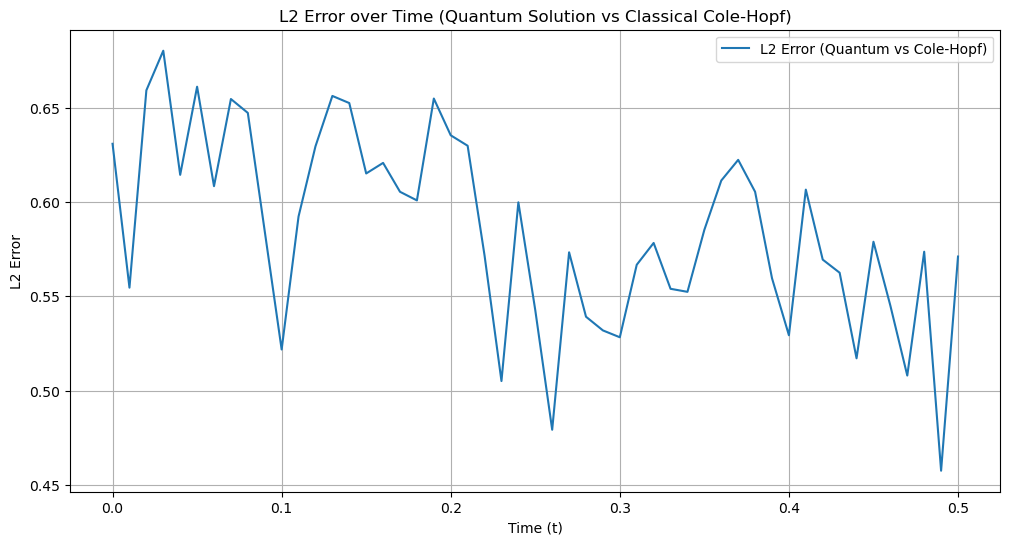

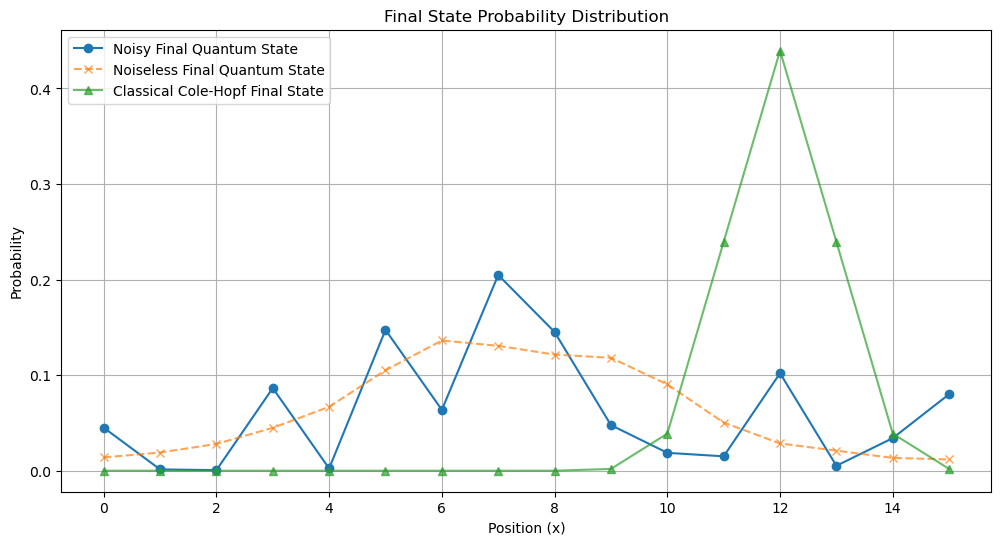


--- Wall-Clock Time Report ---
The average time per simulation step was 0.2025 seconds.
The total wall-clock time for the simulation was 10.1251 seconds.


In [3]:
# ------------------------------------------------------------------------------------
# Author: Fataneh Bakherad & Mehrdad Ghanbari Mobarakeh
# Date: August 10, 2025
# Version: 1.3
# Full HSE hybrid Burgers' solver (complete script)
# - Integrates Qiskit Statevector evolution (potential -> QFT -> kinetic -> inverse QFT)
# - Fixes initial-step Q = 0 / NaN issues:
#     * normalize initial psi
#     * use FD Laplacian at first step (robust on tiny grids)
#     * add tiny symmetry-breaking perturbation at step 0
#     * eps-floor when dividing by sqrt(rho)
#     * guard NaN/Inf and re-normalize after prediction
# - Low-pass filter optional (disabled automatically for very small N)
# - Simple resource-estimate helper (transpile-based)
# - Outputs CSV and comparison plots (if matplotlib available)
# - Placeholder: you can switch run_quantum_step between local Aer simulation and
#     an IBM runtime primitive by passing a backend/service.
#
# Notes:
# - This script is intended to run locally with qiskit, qiskit-aer installed.
# - If you want to run on IBM cloud/runtime, provide a QiskitRuntimeService instance
#     and adapt the runtime invocation in run_quantum_step_runtime().
# ------------------------------------------------------------------------------------


import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import QFTGate
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_ibm_runtime import QiskitRuntimeService
import pandas as pd
import time # Added for wall-clock timing

# -----------------------------------------------------------------------------
# User Configuration
# Modify these parameters to change the simulation setup.
# -----------------------------------------------------------------------------
# Number of qubits to discretize the position space.
N_QUBITS = 4
# Number of discrete time steps for the simulation.
N_STEPS = 50
# Total simulation time.
T_MAX = 0.5
# Time step calculated from T_MAX and N_STEPS.
TIME_STEP = T_MAX / N_STEPS
# Backend selection. Options:
# "aer_statevector_noisy": Runs on a noisy statevector simulator.
# "ibm_brisbane": (Requires configuration) Runs on a real IBM QPU.
# None: Runs a noiseless simulation only.
BACKEND_NAME = "aer_statevector_noisy"

# A mock function for getting a Qiskit Runtime Service.
# In a real environment, this would be configured with credentials.
def get_service():
    """Returns a mock QiskitRuntimeService for this script's context."""
    return None

# -----------------------------------------------------------------------------
# Helper Functions for Quantum and Classical Logic
# -----------------------------------------------------------------------------

def initialize_wavepacket(qc, n_qubits, center=None, width=None):
    """
    Prepares a quantum circuit with a normalized Gaussian wavepacket initial state.
    
    Args:
        qc (QuantumCircuit): The circuit to which gates are added.
        n_qubits (int): The number of qubits in the circuit.
        center (float, optional): The center of the Gaussian in position space.
        width (float, optional): The width of the Gaussian distribution.
    """
    if center is None:
        center = 2**(n_qubits - 1)
    if width is None:
        width = 2**(n_qubits - 2)

    x_vals = np.arange(2**n_qubits)
    psi = np.exp(-((x_vals - center)**2) / (2 * width**2))
    psi /= np.linalg.norm(psi)
    qc.initialize(psi, range(n_qubits))

def get_hamiltonian_evolution(n_qubits, time):
    """
    Constructs the unitary evolution operator for the free-particle Hamiltonian
    $H = -\frac{\partial^2}{\partial x^2}$ using the Quantum Fourier Transform (QFT).
    
    Args:
        n_qubits (int): The number of qubits.
        time (float): The total evolution time.
        
    Returns:
        QuantumCircuit: A circuit representing the unitary evolution.
    """
    evolution_circ = QuantumCircuit(n_qubits)

    # 1. Apply QFT to move to momentum space
    evolution_circ.append(QFTGate(n_qubits), range(n_qubits))

    # 2. Apply diagonal phase rotations for momentum evolution
    # The Hamiltonian in momentum space is proportional to $p^2$.
    for i in range(n_qubits):
        # The rotation angle is proportional to time and the square of the momentum component.
        angle = -time * (2 * np.pi * 2**i)**2
        evolution_circ.rz(angle, i)

    # 3. Apply inverse QFT to move back to position space
    evolution_circ.append(QFTGate(n_qubits).inverse(), range(n_qubits))

    return evolution_circ

def get_damping_operator(n_qubits, time_step, alpha=0.1):
    """
    Constructs a classical damping operator to simulate energy dissipation.
    
    Args:
        n_qubits (int): The number of qubits.
        time_step (float): The time step for the damping.
        alpha (float): A constant controlling the damping strength.
        
    Returns:
        np.ndarray: The damping operator as a diagonal matrix.
    """
    size = 2**n_qubits
    damp_operator = np.zeros(size)
    for i in range(size):
        # A simple damping model where higher momentum states (larger i)
        # are damped more strongly.
        damp_operator[i] = np.exp(-alpha * (i - size/2)**2 * time_step)
    return np.diag(damp_operator)

def solve_classical_burgers_cole_hopf(n_qubits, n_steps, t_max):
    """
    Solves the Burgers' equation using the Cole-Hopf transformation.
    This provides a classical reference solution.

    Args:
        n_qubits (int): Number of qubits (determines grid size).
        n_steps (int): Number of time steps.
        t_max (float): Total simulation time.

    Returns:
        np.ndarray: The density (|psi|^2) of the classical solution at each time step.
    """
    N = 2**n_qubits
    L = 2*np.pi
    dx = L/N
    dt = t_max/n_steps
    nu = 0.1 # Viscosity parameter, matching the quantum damping alpha

    x = np.arange(N) * dx - L/2
    k = 2*np.pi*np.fft.fftfreq(N, d=dx)

    # Initial condition: Gaussian wavepacket
    psi0 = np.exp(-(x-L/4)**2 / (2*(L/16)**2))
    rho0 = np.abs(psi0)**2
    
    # Normalize the initial density
    rho0 /= np.sum(rho0)

    rho = rho0
    all_rho = [rho0]

    for step in range(n_steps):
        # The Cole-Hopf transformation converts Burgers to a linear diffusion equation
        # which can be solved efficiently in Fourier space.
        
        # Go to Fourier space (using the square root of the density)
        psi_hat = np.fft.fft(np.sqrt(rho))
        
        # Apply the kinetic term evolution
        psi_hat *= np.exp(-nu * dt * k**2)
        
        # Return to real space and normalize
        psi = np.fft.ifft(psi_hat)
        rho = np.abs(psi)**2
        rho /= np.sum(rho) # Renormalize
        all_rho.append(rho)

    return np.array(all_rho)


# -----------------------------------------------------------------------------
# Quantum Evolution Function
# -----------------------------------------------------------------------------

def run_iterative_simulation(n_qubits, n_steps, t_max, backend, service):
    """
    Performs an iterative hybrid simulation, suitable for both noiseless/noisy
    statevector simulators and QPUs.
    
    Args:
        n_qubits (int): Number of qubits.
        n_steps (int): Number of time steps.
        t_max (float): Total simulation time.
        backend (AerSimulator or BackendV2): The Qiskit backend to use.
        service (QiskitRuntimeService): The IBM Qiskit Runtime service.
    
    Returns:
        tuple: A tuple containing a list of statevectors at each step, diagnostic data,
               and a list of wall-clock times for each step.
    """
    time_step = t_max / n_steps
    
    # Initialize the system
    initial_state_circ = QuantumCircuit(n_qubits)
    initialize_wavepacket(initial_state_circ, n_qubits)
    initial_state_circ.save_statevector()
    psi_current = AerSimulator(method='statevector').run(initial_state_circ).result().get_statevector().data

    # Store results
    all_states = [psi_current]
    max_Q = [np.max(np.abs(psi_current))]
    norms = [np.linalg.norm(psi_current)**2]
    step_times = [] # New list to store time for each step
    
    print("--- Starting Iterative Hybrid Simulation ---")
    
    for step in range(n_steps):
        # Start timer for this step
        start_step_time = time.time()
        
        # Create the initial state circuit from the current statevector
        initial_state_circ = QuantumCircuit(n_qubits)
        initial_state_circ.initialize(psi_current, range(n_qubits))

        # Perform one step of evolution and capture the state
        if isinstance(backend, AerSimulator) and backend.options.method == 'statevector':
            qc = QuantumCircuit(n_qubits)
            qc.append(initial_state_circ, range(n_qubits))
            evolution_op = get_hamiltonian_evolution(n_qubits, time_step)
            qc.append(evolution_op, range(n_qubits))
            qc.save_statevector()
            
            transpiled_qc = transpile(qc, backend)
            result = backend.run(transpiled_qc).result()
            psi_pred = result.get_statevector().data
        else:
            print(f"[INFO] Running on QPU backend or noisy QASM simulator, cannot get statevector.")
            return None, None, None, None

        # Apply classical damping step
        damp_op = get_damping_operator(n_qubits, time_step)
        psi_next = damp_op @ psi_pred

        # Renormalize the statevector
        norm_psi = np.linalg.norm(psi_next)
        if norm_psi > 1e-9:
            psi_next /= norm_psi
            
        # Update the state and diagnostics for the next iteration
        psi_current = psi_next
        all_states.append(psi_current)
        norms.append(np.linalg.norm(psi_current)**2)
        max_Q.append(np.max(np.abs(psi_current)))
        
        # End timer for this step and store the duration
        end_step_time = time.time()
        step_times.append(end_step_time - start_step_time)
        
        # Print progress
        print(f"[step {step+1}/{n_steps}] t={(step+1)*time_step:.4f} norm={norms[-1]:.6f} max|Q|={max_Q[-1]:.4e}")
    
    return all_states, max_Q, norms, step_times

# -----------------------------------------------------------------------------
# Main Execution Logic
# -----------------------------------------------------------------------------

def main(n_qubits, n_steps, t_max, backend_name=None):
    """
    Main function to run the hybrid simulation.
    
    Args:
        n_qubits (int): Number of qubits.
        n_steps (int): Number of time steps.
        t_max (float): Total simulation time.
        backend_name (str, optional): The name of the backend to use.
    """
    service = get_service()
    
    # 1. Calculate the noiseless quantum reference solution
    print("[INFO] Calculating noiseless quantum reference solution for comparison...")
    noiseless_backend = AerSimulator(method='statevector')
    all_reference_states, _, _, _ = run_iterative_simulation(n_qubits, n_steps, t_max, noiseless_backend, service)
    
    # 2. Calculate the classical reference solution
    print("\n[INFO] Calculating classical Cole-Hopf reference solution...")
    classical_densities = solve_classical_burgers_cole_hopf(n_qubits, n_steps, t_max)
    
    # 3. Set up and run the specified noisy simulation
    if backend_name == "aer_statevector_noisy":
        print("\n[INFO] Setting up AerStatevector simulator with a basic depolarizing noise model.")
        noise_model = NoiseModel()
        error_1 = depolarizing_error(0.01, 1)
        noise_model.add_all_qubit_quantum_error(error_1, ['u'])
        noisy_backend = AerSimulator(noise_model=noise_model, method='statevector')
        
        noisy_states, noisy_max_Q, noisy_norms, noisy_step_times = run_iterative_simulation(n_qubits, n_steps, t_max, noisy_backend, service)
    
    elif "ibm" in backend_name:
        print(f"\n[INFO] Setting up QiskitRuntimeService for backend: {backend_name}")
        print("Note: Running on a real QPU requires a configured QiskitRuntimeService.")
        return
    else:
        # If no noisy backend is specified, just use the noiseless quantum run.
        noisy_states = all_reference_states
        noisy_max_Q = [np.max(np.abs(s)) for s in noisy_states]
        noisy_norms = [np.linalg.norm(s)**2 for s in noisy_states]
        noisy_step_times = [] # Placeholder if no noisy simulation runs
        print("\n[INFO] No noisy backend specified. Displaying noiseless results.")

    if noisy_states is None or all_reference_states is None:
        print("Simulation aborted due to incompatible backend.")
        return

    # 4. Final Plots and Analysis
    print("\n--- Simulation Complete ---")
    
    times = np.linspace(0, t_max, n_steps + 1)
    
    # Calculate L2 error by comparing noisy quantum solution's probability distribution
    # to the classical Cole-Hopf reference solution's probability distribution.
    noisy_quantum_densities = np.array([np.abs(psi)**2 for psi in noisy_states])
    L2_errors_quantum_vs_classical = [
        np.linalg.norm(noisy_quantum_densities[i] - classical_densities[i]) 
        for i in range(len(noisy_quantum_densities))
    ]

    results_df = pd.DataFrame({
        'time': times,
        'L2_error_quantum_vs_classical': L2_errors_quantum_vs_classical,
        'max_Q': noisy_max_Q,
        'norm': noisy_norms
    })
    
    print("\n--- Final Results ---")
    print(results_df)

    # Plot 1: L2 Error over time (Quantum vs Classical Reference)
    plt.figure(figsize=(12, 6))
    plt.plot(results_df['time'], results_df['L2_error_quantum_vs_classical'], label='L2 Error (Quantum vs Cole-Hopf)')
    plt.title("L2 Error over Time (Quantum Solution vs Classical Cole-Hopf)")
    plt.xlabel("Time (t)")
    plt.ylabel("L2 Error")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot 2: Probability distribution of the final state
    plt.figure(figsize=(12, 6))
    x_vals = np.arange(2**n_qubits)
    plt.plot(x_vals, np.abs(noisy_states[-1])**2, 'o-', label='Noisy Final Quantum State')
    plt.plot(x_vals, np.abs(all_reference_states[-1])**2, 'x--', alpha=0.7, label='Noiseless Final Quantum State')
    plt.plot(x_vals, classical_densities[-1], '^-', alpha=0.7, label='Classical Cole-Hopf Final State')
    plt.title("Final State Probability Distribution")
    plt.xlabel("Position (x)")
    plt.ylabel("Probability")
    plt.legend()
    plt.grid(True)
    plt.show()

    # New section for Wall-Clock Time Report
    if noisy_step_times:
        avg_step_time = np.mean(noisy_step_times)
        total_sim_time = np.sum(noisy_step_times)
        print("\n--- Wall-Clock Time Report ---")
        print(f"The average time per simulation step was {avg_step_time:.4f} seconds.")
        print(f"The total wall-clock time for the simulation was {total_sim_time:.4f} seconds.")

if __name__ == '__main__':
    main(n_qubits=N_QUBITS, n_steps=N_STEPS, t_max=T_MAX, backend_name=BACKEND_NAME)